# HW: MCMC Bayesian Linear Regression

## Preliminarires

### Imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

### Random Number Generator

<a id='rng'></a>

In [2]:
seed=396840
rng=np.random.default_rng(seed)

###  Input Data Generation
<a id='data'></a>

In [3]:
N=20
X=rng.normal(0,1,size=N)
alpha0=-1.5
beta0=2.
sigma0=2
Y=alpha0+beta0*X+sigma0*rng.normal(0,1,size=N)

Text(0, 0.5, 'Y')

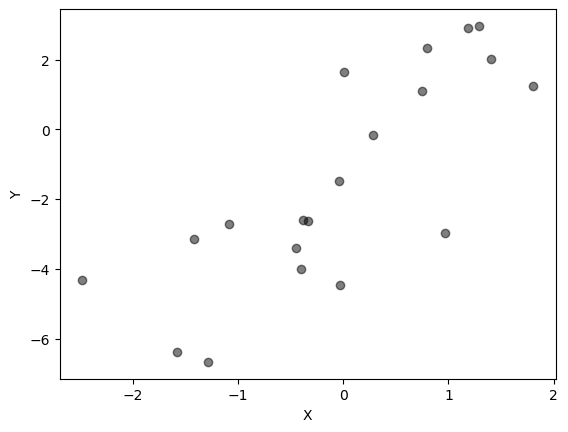

In [4]:
plt.scatter(X,Y,color="k",alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")

### Code

### Metropolis Algorithm Step

In [5]:
def mc_step(loss,theta,gen,dtheta,*args):
    D=len(theta)
    l0=loss(theta,*args)
    # dtheta is the jump proposal size
    theta1=theta+dtheta*gen.normal(size=D)
    l1=loss(theta1,*args)
    alpha=np.exp( l0-l1)
    u=gen.uniform() # u \sim U[0,1]
    if (u<alpha):
        return theta1
    else:
        return theta

#### Monte Carlo Chain

In [6]:
def mc_chain(T_warmup,T,loss,theta0,gen,dtheta,*args):
    theta=theta0.copy()
    for t in range(T_warmup): # skip warm up period 
        theta=mc_step(loss,theta,gen,dtheta,*args)
    chain=[]
    for t in range(T): # keep relaxed chain
        chain.append(theta)
        theta=mc_step(loss,theta,gen,dtheta,*args)
    return np.array(chain).T # shape = (nvars , T)

#### Mutiple chain MC Sampling

In [7]:
def mc_sample(n_chains,T_warmup,T,loss,dist_theta0,gen,dtheta,*args):
    D=len(dist_theta0) # number of parameters
    chains=np.empty((n_chains,D,T))
    for n in range(n_chains):
        theta0=np.empty(D)
        for d in range(D
                      ):
            theta0[d]=dist_theta0[d].rvs(random_state=gen)
        chains[n]=mc_chain(T_warmup,T,loss,theta0,gen,dtheta,*args)
    return chains # shape (n_chains,D,T)

#### Chain Convergence: $\hat{R}$

In [8]:
def R_hat(chains):
    T_s=chains.shape[-1]//2
    split_chains0=chains[:,:,:T_s]
    split_chains1=chains[:,:,T_s:]
    split_chains=np.concatenate([split_chains0,split_chains1])
    chain_mean=split_chains.mean(axis=-1)
    chain_mean_var=chain_mean.var(axis=0,ddof=1)
    chain_var=split_chains.var(axis=-1,ddof=1)
    in_chain_var=np.mean(chain_var,axis=0)
    return np.sqrt((T_s-1)/T_s+chain_mean_var/in_chain_var)

## Problem 1: Bayesian Regresion



We would like to model
$$
    y\sim \hat{y} + \mathcal{N}(0,\sigma)
$$
where 
$$
    \hat{y} = \alpha  + \beta x
$$

###  Problem 1.1


Write the **log likelihood** function:
$$
   L_{\text{likelihood}}(\theta;\{x_i,y_i\}))=\sum_{i=1}^N  \log p( y_i | x_i, \theta)
$$

where 
$$
    \theta = (\theta_1,\theta_2,\theta_3) = (\alpha,\beta, \log \sigma)
$$
and
$$
    p(y|x_i,\theta)  = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \left \{-\frac{(y-\hat{y})^2}{2\sigma^2}\right\}
$$

[HINTS] 
1. If you define the distrition in terms of [scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html),
you can use the method `logpdf(z)` to compute $p(y|x,\theta)$ without having to write
explicit formulas for the normal distribution formula.
2. Performance of the likelihood function will be better if you use the fact that $y_i -\hat{y_i} \sim \mathcal{N}(0,\sigma)$ which is the same distribution for all observations

In [9]:
def regression_likelihood(theta,X,Y):
    pass

In [10]:
def regression_likelihood(theta,X,Y):
    alpha=theta[0]
    beta=theta[1]
    sigma=np.exp(theta[2])
    dist=stats.norm(0,sigma)
    epsilon=(Y-alpha-beta*X)
    lp=dist.logpdf(epsilon)
    return np.sum(lp)

### Problem 1.2

Select one set of  guess values for $\alpha$, $\beta$ and $\sigma$ and verify you can evaluate the likelihood for the [input data](#data) $X$,$Y$ of 

In [11]:
alpha0=0
beta0=0
sigma0=1

In [12]:
theta0=np.array([alpha0,beta0,np.log(sigma0)])

In [13]:
regression_likelihood(theta0,X,Y)

-131.12977386064745

## Problem 2:  Prior Distribution



We would like to assume that our **prior distribution** for $\alpha$,$\beta$ and $\sigma$ are **independent** and given by:
\begin{align*}
    \alpha &\sim \mathcal{N}(0,1) \\
    \beta  & \sim \mathcal{N}(0,1) \\
    \log \sigma & \sim \mathcal{N}(0,1) 
\end{align*}


### Problem 2.1


Write the regression **prior log probability** function
$$
    L_{\text{prior}}(\theta)=\log p_0(\theta)
$$
where
$$
    p_0(\theta) = \phi(\theta_1)\phi(\theta_2)\phi(\theta_3)
$$
and
$$
    \phi(z) = \frac{1}{\sqrt{2\pi}}e^{-\frac{1}{2}z^2}
$$
and, as before, $\theta_1=\alpha$, $\theta_2\beta$ and $\theta_3=\log \sigma$


In [14]:
def regression_prior(theta):
    pass

In [15]:
def regression_prior(theta):
    alpha=theta[0]
    beta=theta[1]
    lsigma=theta[2]
    alpha_dist=stats.norm(0,1)  # hyper parameters
    beta_dist=stats.norm(0,1)   # 
    lsigma_dist=stats.norm(0,1) # 
    return (alpha_dist.logpdf(alpha)+beta_dist.logpdf(beta)+lsigma_dist.logpdf(lsigma)) 

### Problem 2.2

Reusing the guess values for $\alpha$, $\beta$ and $\sigma$ from problem 2.1 verify that you can evaluate the log prior for the [input data](#data) $X$,$Y$

In [16]:
regression_prior(theta0)

-2.756815599614018

## Problem 3: Bayesian Loss

### Problem 3.1

Write the Bayesian regression loss function
$$
    L(\theta ; \{ x_i, y_i\}) = - L_{\text{likelihood}}(\theta;\{x_i,y_i\})) - L_{\text{prior}}(\theta)
$$

In [17]:
def regression_loss(theta,X,Y):
    pass

In [18]:
def regression_loss(theta,X,Y):
    return -regression_likelihood(theta,X,Y)-regression_prior(theta)

### Problem 3.2

Reusing the guess values for $\alpha$, $\beta$ and $\sigma$ from problem 2.1 verify that you can evaluate the Bayesian regression loss for the [input data](#data) $X$,$Y$

In [19]:
regression_loss(theta0,X,Y)

133.88658946026146

## Problem 4: MCMC Chains

### Problem 4.1 

Select a jump size $\delta \theta$
and, starting from your initial parameter guess use the function `mc_step` to perform **one Metropolis algorithm step**

[HINTS]

The `gen` parameter of `mc_step` is the random number generator defined in [section 2](#rng)

In [20]:
dtheta=0.2

In [21]:
theta1=mc_step(regression_loss,theta0,rng,dtheta,X,Y)
theta1

array([ 0.47855573, -0.14376451,  0.18973977])

### Problem 4.2

Was the metropolis update accepted?  How can you tell?

In [22]:
theta1==theta0

array([False, False, False])

<div class="alert alert-block alert-success"> 
If all the updated parameters before and after the update, that means it was rejected
</div>

### Problem 4.3

Using `mc_chain` generate a single chain with no warm up ($T_{\text{warmup}}=0$)
and a length of 1,000 Monte Carlo steps ($T=1,000$).


In [23]:
chain=mc_chain(0,1000,regression_loss,theta0,rng,dtheta,X,Y)

### Problem 4.4 

Make a graph plotting the chain $\theta_t$ for $\alpha$, $\beta$ and $\sigma$.


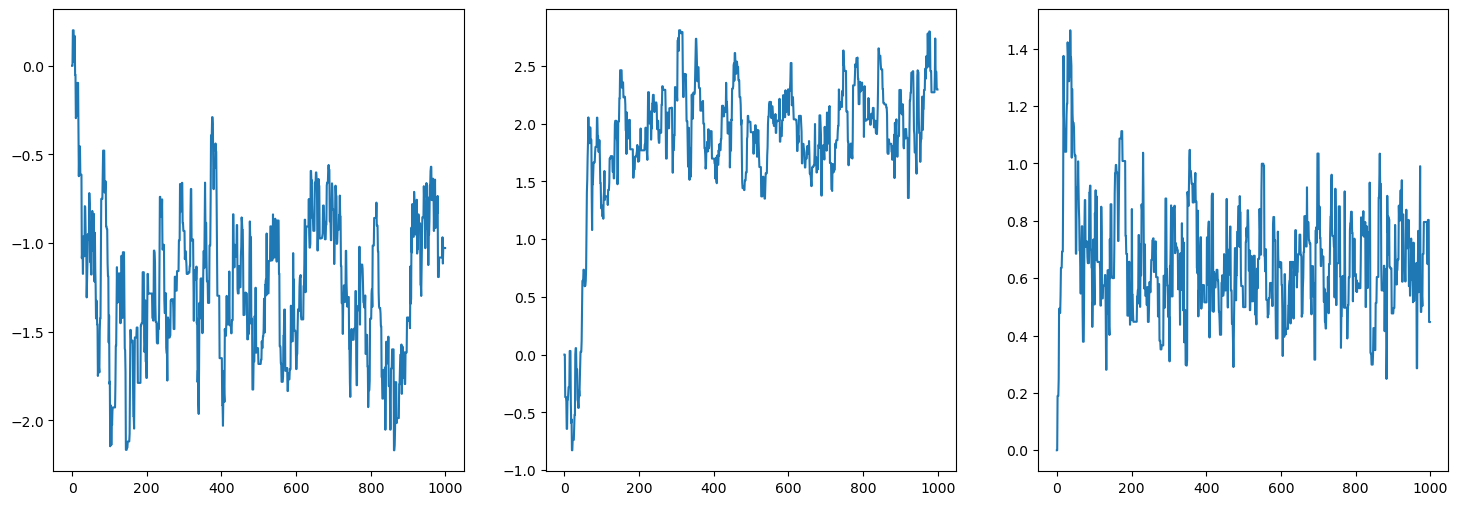

In [24]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.plot(chain[0])

plt.subplot(1,3,2)
plt.plot(chain[1])

plt.subplot(1,3,3)
plt.plot(chain[2])

### Problem 4.5

Use the graph to decide on values of $T_{\text{warmup}}$ and $\delta \theta$ so that the chains equilibrate relatively quickly



It seems $\delta \theta = 0.2$ relaxes relatively quickly.

It seems $T_\text{warmup}=200$ is more than enough.


### Problem 4.6 

Generate a list of [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) distributions
to generate the initial guesses for $\alpha$,$\beta$ and $\log \theta$.

Remember their prior distributions are independent and 
\begin{align*}
    \alpha &\sim \mathcal{N}(0,1) \\
    \beta  & \sim \mathcal{N}(0,1) \\
    \log \sigma & \sim \mathcal{N}(0,1) 
\end{align*}

[HINT] Look at slide 34 of lecture notes for an example.

In [25]:
dist_alpha0=stats.norm(0,1)
dist_beta0=stats.norm(0,1)
dist_lsigma0=stats.norm(0,1)
dist_theta0=[dist_alpha0,dist_beta0,dist_lsigma0]

### Problem 4.6

Use the function `mc_sample` to generate 4 chains with the $T=1,000$, and the $T_\text{warmup}$ and $\delta \theta$ 
that you have selected.

In [26]:
n_chains=4
T_warmup=200
T=1_000

In [27]:
chains=mc_sample(n_chains,T_warmup,T,regression_loss,
                      dist_theta0,rng,dtheta,X,Y)
chains.shape

(4, 3, 1000)

### Problem 4.7

Compute $\hat{R}$ for the chains you just generated.

Adjust $T_\text{warmup}$ and $\delta \theta$ until you get $\hat{R}<1.05$ for all parameters

In [28]:
R_hat(chains)

array([1.02761833, 1.01862288, 1.01330654])

### Problem 4.8

Make 3  histograms, on for each one of the MCMC posterior distribution samples of the parameters $\alpha$,$\beta$ and $\sigma$.

In each graph, include the plot of the pdf of the prior distributio for the parameter $\alpha$,$\beta$ or $\sigma$.

Text(0.5, 0, '$\\sigma$')

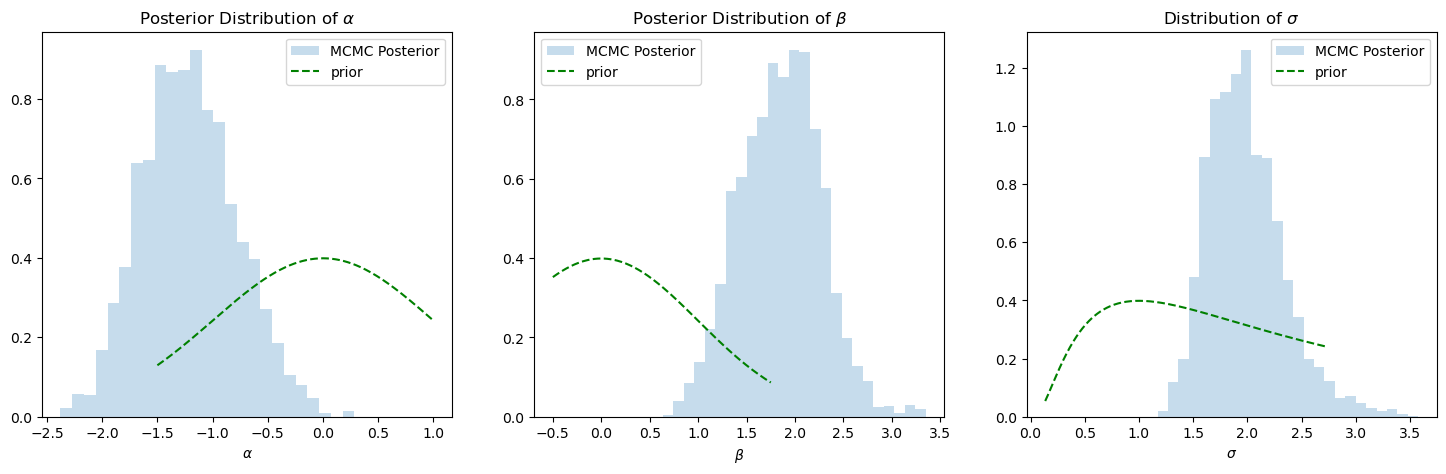

In [29]:
fig=plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.title(r"Posterior Distribution of $\alpha$")
plt.hist(chains[:,0,:].flatten(),density=True,bins=25,alpha=0.25,label="MCMC Posterior")
alphas=np.linspace(-1.5,1,201)
plt.plot(alphas,dist_alpha0.pdf(alphas),label="prior",color="g",linestyle="--")
plt.legend()
plt.xlabel(r"$\alpha$")

plt.subplot(1,3,2)
plt.title(r"Posterior Distribution of $\beta$")
plt.hist(chains[:,1,:].flatten(),density=True,bins=25,alpha=0.25,label="MCMC Posterior")
betas=np.linspace(-0.5,1.75,201)
plt.plot(betas,dist_beta0.pdf(betas),label="prior",color="g",linestyle="--")
plt.legend()
plt.xlabel(r"$\beta$")

plt.subplot(1,3,3)
plt.title(r"Distribution of $\sigma$")
plt.hist(np.exp(chains[:,2,:].flatten()),density=True,bins=25,alpha=0.25,label="MCMC Posterior")
lsigmas=np.linspace(-2,1,201)
plt.plot(np.exp(lsigmas),dist_lsigma0.pdf(lsigmas),label="prior",color="g",linestyle="--")
plt.legend()
plt.xlabel(r"$\sigma$")

## Problem 5: Comparison with (Frequentitst) Linear Regression

### Problem 5.1

Compute the Posterior mean of $\alpha$, $\beta$ and $\sigma$ using the MCMC change you generated

In [30]:
alpha_mean=chains[:,0,:].mean()
beta_mean=chains[:,1,:].mean()
sigma_mean=np.exp(chains[:,2,:]).mean()
alpha_mean,beta_mean,sigma_mean

(-1.2122549347189775, 1.8488055762881759, 1.9864063869569737)

### Problem 5.2 

Compute the Posterior standard deviation of $\alpha$, $\beta$ and $\sigma$ using the MCMC change you generated

In [31]:
alpha_std=chains[:,0,:].std()
beta_std=chains[:,1,:].std()
sigma_std=np.exp(chains[:,2,:]).std()
alpha_std,beta_std,sigma_std

(0.42758175140890686, 0.41963425481331595, 0.3511060222835384)

### Problem 5.3 

Use [statmodels.OLS](https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html)
to perform an **Ordinary Least Square** regression.

Compare the mean and standard deviation of the Bayesian estimates of $\alpha$ and $\beta$ to the  regression coeffients obtained by ordinary least squares.

Can you explain the differences?

In [32]:
model=OLS(Y,add_constant(X))
res=model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     30.87
Date:                Sun, 30 Apr 2023   Prob (F-statistic):           2.83e-05
Time:                        08:25:54   Log-Likelihood:                -40.265
No. Observations:                  20   AIC:                             84.53
Df Residuals:                      18   BIC:                             86.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4303      0.427     -3.346      0.004      -2.328      -0.532
x1             2.1403      0.385      5.556      0.000       1.331       2.950
==============================================================================
Omnibus:                        1.011   Durbin-Watson:                   2.930
Prob(Omnibus):                  0.603   Jarque-Bera (JB):                0.882
Skew:                          -0.285   Prob(JB):                        0.643
Kurtosis:                       2.144   Cond. No.                         1.12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
res.params

array([-1.43030994,  2.14033734])

In [34]:
alpha_mean,beta_mean

(-1.2122549347189775, 1.8488055762881759)

<div class="alert alert-block alert-success">
    
Because the number of data points $N=20$ is small the Bayesian results are **shrunk** towards the priors (we assume $\alpha\sim\mathcal{N}(0,1)$ and $\beta\sim\mathcal{N}(0,1)$).

When the data is small, the expected value of parameters in a Bayesian estimates interpolates between the prior expected value and the frequentist estimate derived purely from the data.
    
 The standard deviations are comparable in both methods.
</div>

## Problem 6: Posterior Distribution

### Problem 6.1 

Using the example from slide 41 of the lecture notes write a function to sample 
the **predictive posterior distribution** of $y$ given a value of $x$

In [35]:
def sample_posterior(x,chains,gen,nsamples):
    pass

In [36]:
def sample_posterior(x,chains,gen,nsamples):
    # (chain, parameter, sample) -> (parameter,sample) 
    used_chains=chains.transpose([0,2,1]).reshape(-1,3)
    theta_samples=gen.choice(used_chains,nsamples)
    alpha=theta_samples[:,0] #  nsample means
    beta=theta_samples[:,1]
    sigma=np.exp(theta_samples[:,2]) # nsample stdevs
    y_hat= alpha+beta*x
    y=gen.normal(loc=y_hat,scale=sigma)
    return y

### Problem 6.2 

Generate 1,000 samples of the posterior predictive  distribution of $y$ when $x=1.0$ and plot them in a histogram:

In [37]:
nsamples=1_000

In [38]:
y_post=sample_posterior(1.0,chains,rng,nsamples)
y_post.shape

(1000,)

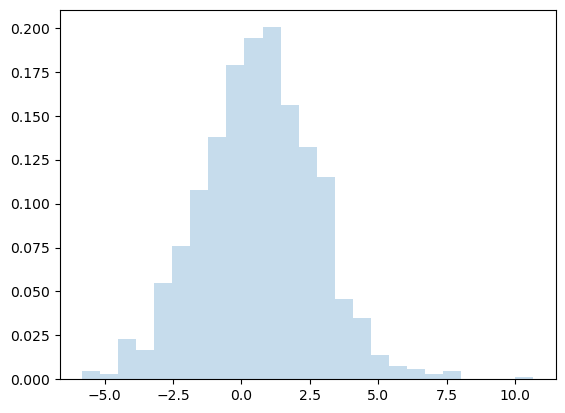

In [39]:
h=plt.hist(y_post,bins=25,alpha=0.25,density=True)

### Problem 6.3

For $x$ values= $-5, -5.1, \dots 2.9,3$  
Generate 1,000 samples of the posterior predictive  distribution of $y$ for each $x$ and compute 
the mean and standard deviation of $y$ for each value of $x$.

Generate two arrays, one for the mean and one for the std deviation of the posterior distribution of $y$.

In [40]:
xs=np.linspace(-5,5,101)
xs

array([-5. , -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4.3, -4.2, -4.1, -4. ,
       -3.9, -3.8, -3.7, -3.6, -3.5, -3.4, -3.3, -3.2, -3.1, -3. , -2.9,
       -2.8, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1, -2. , -1.9, -1.8,
       -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7,
       -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,
        0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,
        1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,  2.4,  2.5,  2.6,
        2.7,  2.8,  2.9,  3. ,  3.1,  3.2,  3.3,  3.4,  3.5,  3.6,  3.7,
        3.8,  3.9,  4. ,  4.1,  4.2,  4.3,  4.4,  4.5,  4.6,  4.7,  4.8,
        4.9,  5. ])

In [41]:
y_means=[]
y_stds=[]
for x in xs:
    y_post=sample_posterior(x,chains,rng,nsamples)
    y_mean=y_post.mean()
    y_std=y_post.std()
    y_means.append(y_mean)
    y_stds.append(y_std)
y_means=np.array(y_means)
y_stds=np.array(y_stds)

In [42]:
len(xs),len(y_means),len(y_stds)

(101, 101, 101)

### Problem 6.4

Make a $X,Y$ plot showing:
1. The original $X$, $Y$ data points.
2. The mean of the posterior distribution of $y$ for each value of $x$.
3. The 1 and 2 standard deviation regions around the mean value of the standard deviation of $y$.

Text(0, 0.5, 'Y')

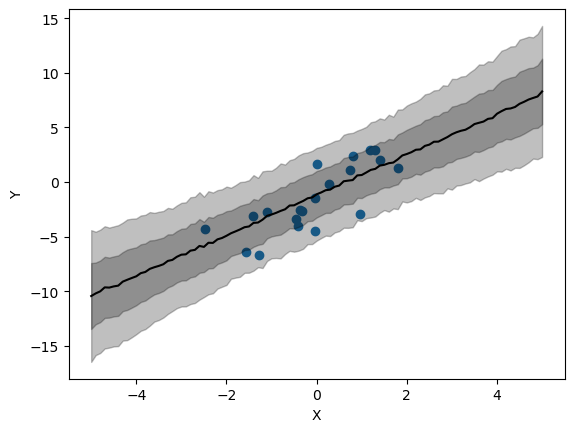

In [43]:
plt.scatter(X,Y)
plt.plot(xs,y_means,"k")
plt.fill_between(xs,y_means-y_stds,y_means+y_stds,color="black",alpha=0.25)
plt.fill_between(xs,y_means-2*y_stds,y_means+2*y_stds,color="black",alpha=0.25)
plt.xlabel("X")
plt.ylabel("Y")

## Problem 7: PYMC

We need to install `pymc` and `arviz` for next class.

This are the installation instructions, you must **get it installed before next class**.



### Problem 7.1

We will be using `pymc3` and `arviz` next week to fit more sofisticated Bayesian Statistical Models.

You should **install `pymc3` and `arviz`** using the following command:
    
    conda install -c conda-forge pymc arviz
 

If you want to get better performance you can also install the c and fortran compilers following the following instructions:

Windows:
    conda install -c conda-forge mw2
 
If you do not use Anaconda, you will need to follow the [pymc installaction instructions](https://docs.pymc.io/en/v3/).


Warning about not finding `g77`, `f77` etc are fine.

In [44]:
import pymc as pm 
import arviz as az

### Problem 7.2 </div>

Make sure the following cells run to completition without errors

In [45]:
with pm.Model() as mod:
    alpha=pm.Normal("alpha",mu=0,sigma=1)
    beta=pm.Normal("beta",mu=0,sigma=1)
    sig=pm.Lognormal("sigma",mu=1,sigma=1)
    y_hat=pm.Deterministic("y_hat",alpha+beta*X)
    y=pm.Normal("y",mu=y_hat,sigma=sig,observed=Y)

In [46]:
with mod:
    trace = pm.sample(1000, tune=500,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 3 seconds.


In [47]:
with mod:
    summary=az.summary(trace, var_names=["alpha","beta","sigma"], fmt="wide",round_to=2)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.19,0.43,-2.04,-0.42,0.01,0.01,3802.70,2636.84,1.0
beta,1.85,0.40,1.05,2.59,0.01,0.00,4057.16,2696.63,1.0
sigma,2.04,0.37,1.42,2.72,0.01,0.01,2927.25,2591.08,1.0
